In [9]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)

## Example: Face Recognition

Use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures to apply SVM for classification:

In [10]:
from PIL import Image
from sklearn.datasets import fetch_lfw_people

In [11]:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Plot some of the pictures:

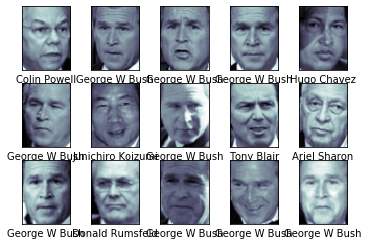

In [12]:
# each image contains 62x47 pixels
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Proceed by simply using each pixel value as a feature, but often it is more effective to use a preprocessor to extract more meaningful features e.g. PCA.

In [14]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA # Principal component analysis (PCA) using randomized SVD
from sklearn.pipeline import make_pipeline

random_pca = PCA(n_components=150, whiten=True, random_state=42,svd_solver='randomized')
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(random_pca, svc)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=42) 

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C':[1, 5, 10, 50], 
              'svc__gamma':[0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

/home/fmillan/anaconda3/envs/ancud/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=150, random_state=42,
                                            svd_solver='randomized', tol=0.0,
                                            whiten=True)),
                                       ('svc',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight='balanced', coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=Tr

In [17]:
grid.best_params_

{'svc__C': 10, 'svc__gamma': 0.001}

In [18]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

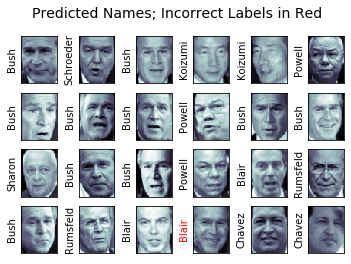

In [19]:
# a few of the test images along with their predicted values
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [20]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
                           target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



---

## Funny time

In [24]:
import joblib

joblib.dump(model, 'extra/face_reco.pkl')

['extra/face_reco.pkl']

In [109]:
new_guys = ['bob', 'barbara', 'bush', 'justin', 'voldemort']

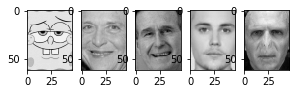

In [115]:
fig = plt.figure(figsize=(4.7, 6.2))
n_cols = len(new_guys)

new_imgs = [Image.open("{}{}{}".format('extra/', x, '.jpg')).convert('L') for x in new_guys]

for ix, img in enumerate(new_imgs):
    fig.add_subplot(1, n_cols, ix+1)
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)

In [116]:
np_img = np.asarray([np.asarray(img, dtype='float32').reshape(62*47,) for img in new_imgs])

In [117]:
np_img.shape

(5, 2914)

In [118]:
clf = joblib.load('extra/face_reco.pkl')
new_preds = clf.predict(np_img)

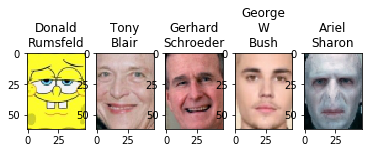

In [119]:
fig = plt.figure()
i = 1

for p, fn in zip(new_preds, new_guys):
    a = fig.add_subplot(1, n_cols, i)
    imgplot = plt.imshow(Image.open("{}{}{}".format('extra/', fn, '.jpg')))
    a.set_title(faces.target_names[p].replace(" ", "\n"))
    i+=1

---

Checking the closest category to a random noise:

In [147]:
rand_pic = np.random.uniform(0., 255., 62*47)

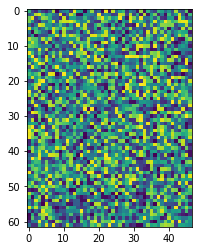

In [148]:
plt.imshow(rand_pic.reshape(62,47));

In [149]:
rand_pic.shape

(2914,)

In [150]:
print(faces.target_names[clf.predict([rand_pic])])

['Colin Powell']


In [152]:
samples = np.asarray([np.random.uniform(0., 255., 62*47) for i in range(10000)])

In [153]:
noisy_preds = clf.predict(samples)

In [164]:
unique, counts = np.unique(noisy_preds, return_counts=True)
res = dict(zip(unique, counts))

for k,v in res.items():
    print("{}:     \t {:.2f}%".format(faces.target_names[k], v/100))

Ariel Sharon:     	 8.32%
Colin Powell:     	 53.54%
Donald Rumsfeld:     	 12.17%
George W Bush:     	 16.38%
Gerhard Schroeder:     	 1.49%
Hugo Chavez:     	 1.05%
Junichiro Koizumi:     	 1.44%
Tony Blair:     	 5.61%
